In [ ]:
!pip install imblearn
!pip install xgboost

In [ ]:
import os
import numpy as np
import pandas as pd
import datetime as dt
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
import pickle
import joblib
import json
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import (train_test_split, StratifiedKFold, GridSearchCV, cross_val_score)
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix,accuracy_score,precision_recall_fscore_support
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import shap

In [ ]:
path = kagglehub.dataset_download("kartik2112/fraud-detection")
print("Path to dataset files:", path)
print(os.listdir(path))

Path to dataset files: /home/naamamai/.cache/kagglehub/datasets/kartik2112/fraud-detection/versions/1
['fraudTest.csv', 'fraudTrain.csv']


In [ ]:
train_path = os.path.join(path, 'fraudTrain.csv')
test_path = os.path.join(path, 'fraudTest.csv')

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

combined_df = pd.concat([train_data, test_data], ignore_index=True)

In [ ]:
# --- Feature Engineering ---

# Age from DOB
combined_df['age'] = dt.date.today().year - pd.to_datetime(combined_df['dob']).dt.year

# Time-based features from transaction time
combined_df['hour'] = pd.to_datetime(combined_df['trans_date_trans_time']).dt.hour
combined_df['daily'] = pd.to_datetime(combined_df['trans_date_trans_time']).dt.day
combined_df['day'] = pd.to_datetime(combined_df['trans_date_trans_time']).dt.dayofweek
combined_df['month'] = pd.to_datetime(combined_df['trans_date_trans_time']).dt.month

# extra features
combined_df['is_night'] = combined_df['hour'].apply(lambda h: 1 if h < 6 or h > 22 else 0)
combined_df['amt_log'] = np.log1p(combined_df['amt'])  # log(amt + 1)

# --- Encoding ---

# Use separate LabelEncoders to encode to numeric values
encoders = {}
for col in ['category', 'gender', 'city', 'state', 'job']:
    le = LabelEncoder()
    combined_df[f'{col}_encoded'] = le.fit_transform(combined_df[col])
    encoders[col] = le  # Save if you need to inverse later

# --- Drop unused original columns ---
combined_df = combined_df.drop(columns=['dob', 'trans_date_trans_time', 'category', 'gender', 'city', 'state', 'job'])

# --- Select features and target ---
input_features = [
    'category_encoded', 'amt', 'amt_log', 'gender_encoded', 'city_encoded',
    'state_encoded', 'city_pop', 'job_encoded', 'age',
    'hour', 'daily', 'day', 'month', 'is_night']

X = combined_df[input_features + ['is_fraud']]

# --- Split and Scale ---
df_train, df_val = train_test_split(X, test_size=0.1, random_state=42, stratify=X['is_fraud'])

scaler = StandardScaler()
scaler.fit(df_train[input_features])

df_train[input_features] = scaler.transform(df_train[input_features])
df_val[input_features] = scaler.transform(df_val[input_features])

# Final training sets
X_train = df_train[input_features]
y_train = df_train['is_fraud']
X_val = df_val[input_features]
y_val = df_val['is_fraud']

Comparative Analysis of Random Forest, XGBoost, and Easy Ensemble Models:

                      Model  Recall (label=1)
0        XGBoost (Balanced)          0.965803
1  Random Forest (Balanced)          0.765803
2             Easy Ensemble          0.926425


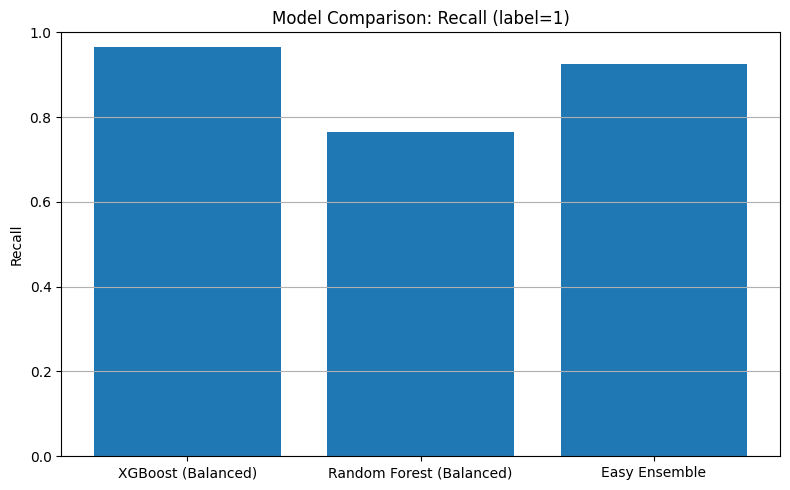

In [ ]:
# --- XGBoost with imbalance handling via scale_pos_weight ---
counter = Counter(y_train)
scale_pos_weight = counter[0] / counter[1]
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_val)

# --- Random Forest with balanced class weights ---
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_val)

# --- Easy Ensemble classifier for built-in resampling ---
ee_model = EasyEnsembleClassifier(n_estimators=10, random_state=42)
ee_model.fit(X_train, y_train)
y_pred_ee = ee_model.predict(X_val)

# --- Calculate Recall for label 1 only ---
models = {
    "XGBoost (Balanced)": y_pred_xgb,
    "Random Forest (Balanced)": y_pred_rf,
    "Easy Ensemble": y_pred_ee
}

summary = {
    "Model": [],
    "Recall (label=1)": []
}

for name, y_pred in models.items():
    report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
    summary["Model"].append(name)
    summary["Recall (label=1)"].append(report["1"]["recall"])

summary_df = pd.DataFrame(summary)
print(summary_df)

# --- Plotting Recall comparison ---
plt.figure(figsize=(8, 5))
plt.bar(summary_df["Model"], summary_df["Recall (label=1)"])
plt.title("Model Comparison: Recall (label=1)")
plt.ylabel("Recall")
plt.ylim(0, 1)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


Comparative Evaluation of XGBoost with Oversampling and Undersampling Techniques:



In [ ]:
# Define param grid for XGBoost
params = {
    'n_estimators': [50, 100],
    'max_depth': [3, 6],
    'learning_rate': [0.1, 0.2],
}

# Stratified K-Fold cross-validation
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Param grid for pipeline models
pipeline_params = {
    'xgb__n_estimators': [50, 100],
    'xgb__max_depth': [3, 6],
    'xgb__learning_rate': [0.1, 0.2],
}

# Initialize storage for models and results
trained_models = {}
summary_list = []

XGBoost Without Imbalance Correction (Baseline Model):



In [ ]:
# Define XGBoost classifier
xgb_baseline = XGBClassifier(eval_metric='logloss', random_state=42)

# Grid search
grid_xgb_baseline = GridSearchCV(xgb_baseline, param_grid=params, cv=kf, scoring='recall', verbose=1, n_jobs=-1)
grid_xgb_baseline.fit(X_train, y_train)

trained_models['XGBoost_baseline'] = grid_xgb_baseline.best_estimator_

# Results
print('✅ Best parameters:', grid_xgb_baseline.best_params_)
print('📊 Best CV Recall score:', grid_xgb_baseline.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


✅ Best parameters: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 100}
📊 Best CV Recall score: 0.8148743865240444


In [ ]:
# Evaluation on validation set
y_val_pred = grid_xgb_baseline.best_estimator_.predict(X_val)
report = classification_report(y_val, y_val_pred, digits=4, output_dict=True)

metrics = {
    'model': 'XGBoost_baseline',
    'recall_1': report['1']['recall'],
    'precision_1': report['1']['precision'],
    'f1_1': report['1']['f1-score'],
    'support_1': report['1']['support'],
    'accuracy': report['accuracy'],
    'macro_f1': report['macro avg']['f1-score'],
    'weighted_f1': report['weighted avg']['f1-score']
}
summary_list.append(metrics)

print("🔍 Evaluation on Validation Set:")
print(classification_report(y_val, y_val_pred, digits=4))
print(f"📌 Recall for class 1 (fraud): {metrics['recall_1']:.4f}\n")

🔍 Evaluation on Validation Set:
              precision    recall  f1-score   support

           0     0.9991    0.9998    0.9994    184275
           1     0.9568    0.8259    0.8865       965

    accuracy                         0.9989    185240
   macro avg     0.9779    0.9129    0.9430    185240
weighted avg     0.9989    0.9989    0.9989    185240

📌 Recall for class 1 (fraud): 0.8259



**On basline model - XGBoost without balancing the classes of target value :**

Best Cross-Validation Recall (Train): 0.8149

Validation Set Recall (Class 1): 0.8259


## Oversampling Methods

### XGBoost with Class Imbalance Handling (scale_pos_weight):

In [ ]:
# Define XGBoost classifier
scale_pos_weight_value = (y_train == 0).sum() / (y_train == 1).sum()
xgb_weighted = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight_value
)

# Grid search
grid_xgb_weighted = GridSearchCV(xgb_weighted, param_grid=params, cv=kf, scoring='recall', verbose=1, n_jobs=-1)
grid_xgb_weighted.fit(X_train, y_train)

trained_models['XGBoost_scale_pos_weight'] = grid_xgb_weighted.best_estimator_

print('✅ Best parameters:', grid_xgb_weighted.best_params_)
print('📊 Best CV Recall score:', grid_xgb_weighted.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
✅ Best parameters: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 50}
📊 Best CV Recall score: 0.9697210851248581


In [ ]:
# Evaluate on validation set
y_val_pred = grid_xgb_weighted.best_estimator_.predict(X_val)
report = classification_report(y_val, y_val_pred, digits=4, output_dict=True)

metrics = {
    'model': 'XGBoost_scale_pos_weight',
    'recall_1': report['1']['recall'],
    'precision_1': report['1']['precision'],
    'f1_1': report['1']['f1-score'],
    'support_1': report['1']['support'],
    'accuracy': report['accuracy'],
    'macro_f1': report['macro avg']['f1-score'],
    'weighted_f1': report['weighted avg']['f1-score']
}
summary_list.append(metrics)

print("🔍 Evaluation on Validation Set:")
print(classification_report(y_val, y_val_pred, digits=4))
print(f"📌 Recall for class 1 (fraud): {metrics['recall_1']:.4f}\n")

🔍 Evaluation on Validation Set:
              precision    recall  f1-score   support

           0     0.9999    0.9852    0.9925    184275
           1     0.2571    0.9751    0.4069       965

    accuracy                         0.9852    185240
   macro avg     0.6285    0.9802    0.6997    185240
weighted avg     0.9960    0.9852    0.9895    185240

📌 Recall for class 1 (fraud): 0.9751



**On model - XGBoost with Class Imbalance Handling (scale_pos_weight):**

Best Cross-Validation Recall (Train): 0.969

Validation Set Recall (Class 1): 0.9751



### Random Oversampling

In [ ]:
# Define oversampling strategy
ros = RandomOverSampler(random_state=42)
X_over, y_over = ros.fit_resample(X_train, y_train)
print('Genuine:', y_over.value_counts()[0], '/', round(y_over.value_counts()[0]/len(y_over) * 100,2), '% of the dataset')
print('Frauds:', y_over.value_counts()[1], '/',round(y_over.value_counts()[1]/len(y_over) * 100,2), '% of the dataset')

Genuine: 1658468 / 50.0 % of the dataset
Frauds: 1658468 / 50.0 % of the dataset


In [ ]:
# Build pipeline using named steps (xgb is explicitly named here)
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
pipeline_ros = Pipeline(steps=[
    ('oversample', RandomOverSampler(random_state=42)),
    ('xgb', xgb_model)
])

# Cross-val evaluation
score2 = cross_val_score(pipeline_ros, X_train, y_train, scoring='recall', cv=kf)
print("📈 Cross Validation Recall Scores are:", score2)
print("📊 Average Cross Validation Recall score:", score2.mean())

# Grid Search
grid_ros = GridSearchCV(
    estimator=pipeline_ros,
    param_grid=pipeline_params,
    cv=kf,
    scoring='recall',
    return_train_score=True,
    verbose=1,
    n_jobs=-1
)
grid_ros.fit(X_train, y_train)

trained_models['RandomOverSampling_XGBoost'] = grid_ros.best_estimator_

print('✅ Best parameters:', grid_ros.best_params_)
print('📊 Best CV Recall score:', grid_ros.best_score_)


📈 Cross Validation Recall Scores are: [0.95234807 0.9433506  0.95198618]
📊 Average Cross Validation Recall score: 0.9492282846210364
Fitting 3 folds for each of 8 candidates, totalling 24 fits
✅ Best parameters: {'xgb__learning_rate': 0.2, 'xgb__max_depth': 6, 'xgb__n_estimators': 50}
📊 Best CV Recall score: 0.9707568774511207


In [ ]:
# Evaluate on validation set
y_val_pred = grid_ros.best_estimator_.predict(X_val)
report = classification_report(y_val, y_val_pred, digits=4, output_dict=True)

metrics = {
    'model': 'RandomOverSampling_XGBoost',
    'recall_1': report['1']['recall'],
    'precision_1': report['1']['precision'],
    'f1_1': report['1']['f1-score'],
    'support_1': report['1']['support'],
    'accuracy': report['accuracy'],
    'macro_f1': report['macro avg']['f1-score'],
    'weighted_f1': report['weighted avg']['f1-score']
}
summary_list.append(metrics)

print("🔍 Evaluation on Validation Set:")
print(classification_report(y_val, y_val_pred, digits=4))
print(f"📌 Recall for class 1 (fraud): {metrics['recall_1']:.4f}\n")

🔍 Evaluation on Validation Set:
              precision    recall  f1-score   support

           0     0.9998    0.9858    0.9928    184275
           1     0.2642    0.9710    0.4154       965

    accuracy                         0.9858    185240
   macro avg     0.6320    0.9784    0.7041    185240
weighted avg     0.9960    0.9858    0.9898    185240

📌 Recall for class 1 (fraud): 0.9710



**On model - XGBoost with Random Oversampling:**

Best Cross-Validation Recall (Train): 0.970

Validation Set Recall (Class 1): 0.971


### SMOTE

In [ ]:
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
pipeline_smote = Pipeline(steps=[
    ('oversample', SMOTE(random_state=42)),
    ('xgb', xgb_model)
])

# Cross-validation evaluation
score2 = cross_val_score(pipeline_smote, X_train, y_train, scoring='recall', cv=kf)
print("📈 Cross Validation Recall Scores are:", score2)
print("📊 Average Cross Validation Recall score:", score2.mean())

# Grid Search
grid_smote = GridSearchCV(
    estimator=pipeline_smote,
    param_grid=pipeline_params,
    cv=kf,
    scoring='recall',
    return_train_score=True,
    verbose=1,
    n_jobs=-1
)
grid_smote.fit(X_train, y_train)

# Store the model
trained_models['SMOTE_XGBoost'] = grid_smote.best_estimator_

print('✅ Best parameters:', grid_smote.best_params_)
print('📊 Best CV Recall score:', grid_smote.best_score_)

📈 Cross Validation Recall Scores are: [0.87569061 0.86286701 0.87841105]
📊 Average Cross Validation Recall score: 0.8723228911217347
Fitting 3 folds for each of 8 candidates, totalling 24 fits
✅ Best parameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 50}
📊 Best CV Recall score: 0.9376003110716705


In [ ]:
# Evaluate on validation set
y_val_pred = grid_smote.best_estimator_.predict(X_val)
report = classification_report(y_val, y_val_pred, digits=4, output_dict=True)

metrics = {
    'model': 'SMOTE_XGBoost',
    'recall_1': report['1']['recall'],
    'precision_1': report['1']['precision'],
    'f1_1': report['1']['f1-score'],
    'support_1': report['1']['support'],
    'accuracy': report['accuracy'],
    'macro_f1': report['macro avg']['f1-score'],
    'weighted_f1': report['weighted avg']['f1-score']
}
summary_list.append(metrics)

print("🔍 Evaluation on Validation Set:")
print(classification_report(y_val, y_val_pred, digits=4))
print(f"📌 Recall for class 1 (fraud): {metrics['recall_1']:.4f}\n")

🔍 Evaluation on Validation Set:
              precision    recall  f1-score   support

           0     0.9997    0.9808    0.9902    184275
           1     0.2053    0.9482    0.3376       965

    accuracy                         0.9806    185240
   macro avg     0.6025    0.9645    0.6639    185240
weighted avg     0.9956    0.9806    0.9868    185240

📌 Recall for class 1 (fraud): 0.9482



**On model - XGBoost with SMOTE:**

Best Cross-Validation Recall (Train): 0.937

Validation Set Recall (Class 1): 0.948

## Undersampling Methods

### RandomUnderSampler

In [ ]:
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
pipeline_rus = Pipeline(steps=[
    ('undersample', RandomUnderSampler(random_state=42)),
    ('xgb', xgb_model)
])

# Cross-validation evaluation
score2 = cross_val_score(pipeline_rus, X_train, y_train, scoring='recall', cv=kf)
print("📈 Cross Validation Recall Scores are:", score2)
print("📊 Average Cross Validation Recall score:", score2.mean())

# Grid Search
grid_rus = GridSearchCV(
    estimator=pipeline_rus,
    param_grid=pipeline_params,
    cv=kf,
    scoring='recall',
    return_train_score=True,
    verbose=1,
    n_jobs=-1
)
grid_rus.fit(X_train, y_train)

# Store the model
trained_models['RandomUnderSampler_XGBoost'] = grid_rus.best_estimator_

print('✅ Best parameters:', grid_rus.best_params_)
print('📊 Best CV Recall score:', grid_rus.best_score_)

📈 Cross Validation Recall Scores are: [0.98066298 0.97478411 0.97547496]
📊 Average Cross Validation Recall score: 0.9769740169276425
Fitting 3 folds for each of 8 candidates, totalling 24 fits
✅ Best parameters: {'xgb__learning_rate': 0.2, 'xgb__max_depth': 6, 'xgb__n_estimators': 100}
📊 Best CV Recall score: 0.9768589951558061


In [ ]:
# Evaluate on validation set
y_val_pred = grid_rus.best_estimator_.predict(X_val)
report = classification_report(y_val, y_val_pred, digits=4, output_dict=True)

metrics = {
    'model': 'RandomUnderSampler_XGBoost',
    'recall_1': report['1']['recall'],
    'precision_1': report['1']['precision'],
    'f1_1': report['1']['f1-score'],
    'support_1': report['1']['support'],
    'accuracy': report['accuracy'],
    'macro_f1': report['macro avg']['f1-score'],
    'weighted_f1': report['weighted avg']['f1-score']
}
summary_list.append(metrics)

print("🔍 Evaluation on Validation Set:")
print(classification_report(y_val, y_val_pred, digits=4))
print(f"📌 Recall for class 1 (fraud): {metrics['recall_1']:.4f}\n")

🔍 Evaluation on Validation Set:
              precision    recall  f1-score   support

           0     0.9999    0.9780    0.9888    184275
           1     0.1887    0.9782    0.3164       965

    accuracy                         0.9780    185240
   macro avg     0.5943    0.9781    0.6526    185240
weighted avg     0.9957    0.9780    0.9853    185240

📌 Recall for class 1 (fraud): 0.9782



**On model - XGBoost with RandomUnderSampler:**

Best Cross-Validation Recall (Train): 0.976

Validation Set Recall (Class 1): 0.9782


## combination of oversampling and undersampling:

### SMOTE + TomekLinks

In [ ]:
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
pipeline_smote_tomek = Pipeline(steps=[
    ('resample', SMOTETomek(random_state=42)),
    ('xgb', xgb_model)
])

# Cross-validation evaluation
score2 = cross_val_score(pipeline_smote_tomek, X_train, y_train, scoring='recall', cv=kf)
print("📈 Cross Validation Recall Scores are:", score2)
print("📊 Average Cross Validation Recall score:", score2.mean())

# Grid Search
grid_smote_tomek = GridSearchCV(
    estimator=pipeline_smote_tomek,
    param_grid=pipeline_params,
    cv=kf,
    scoring='recall',
    return_train_score=True,
    verbose=1,
    n_jobs=-1
)
grid_smote_tomek.fit(X_train, y_train)

# Store the model
trained_models['SMOTE_TomekLinks_XGBoost'] = grid_smote_tomek.best_estimator_

print('✅ Best parameters:', grid_smote_tomek.best_params_)
print('📊 Best CV Recall score:', grid_smote_tomek.best_score_)

📈 Cross Validation Recall Scores are: [0.87569061 0.86286701 0.87841105]
📊 Average Cross Validation Recall score: 0.8723228911217347
Fitting 3 folds for each of 8 candidates, totalling 24 fits
✅ Best parameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 50}
📊 Best CV Recall score: 0.9376003110716705


In [ ]:
# Evaluate on validation set
y_val_pred = grid_smote_tomek.best_estimator_.predict(X_val)
report = classification_report(y_val, y_val_pred, digits=4, output_dict=True)

metrics = {
    'model': 'SMOTE_TomekLinks_XGBoost',
    'recall_1': report['1']['recall'],
    'precision_1': report['1']['precision'],
    'f1_1': report['1']['f1-score'],
    'support_1': report['1']['support'],
    'accuracy': report['accuracy'],
    'macro_f1': report['macro avg']['f1-score'],
    'weighted_f1': report['weighted avg']['f1-score']
}
summary_list.append(metrics)

print("🔍 Evaluation on Validation Set:")
print(classification_report(y_val, y_val_pred, digits=4))
print(f"📌 Recall for class 1 (fraud): {metrics['recall_1']:.4f}\n")

🔍 Evaluation on Validation Set:
              precision    recall  f1-score   support

           0     0.9997    0.9808    0.9902    184275
           1     0.2053    0.9482    0.3376       965

    accuracy                         0.9806    185240
   macro avg     0.6025    0.9645    0.6639    185240
weighted avg     0.9956    0.9806    0.9868    185240

📌 Recall for class 1 (fraud): 0.9482



**On model - XGBoost with combination SMOTE + TomekLinks:**

Best Cross-Validation Recall (Train): 0.9376

Validation Set Recall (Class 1): 0.9482

### SMOTE + RandomUnderSampler

In [ ]:
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
pipeline_smote_rus = Pipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('undersample', RandomUnderSampler(random_state=42)),
    ('xgb', xgb_model)
])

# Cross-validation evaluation
score2 = cross_val_score(pipeline_smote_rus, X_train, y_train, scoring='recall', cv=kf)
print("📈 Cross Validation Recall Scores are:", score2)
print("📊 Average Cross Validation Recall score:", score2.mean())

# Grid Search
grid_smote_rus = GridSearchCV(
    estimator=pipeline_smote_rus,
    param_grid=pipeline_params,
    cv=kf,
    scoring='recall',
    return_train_score=True,
    verbose=1,
    n_jobs=-1
)
grid_smote_rus.fit(X_train, y_train)

# Store the model
trained_models['SMOTE_RandomUnderSampler_XGBoost'] = grid_smote_rus.best_estimator_

print('✅ Best parameters:', grid_smote_rus.best_params_)
print('📊 Best CV Recall score:', grid_smote_rus.best_score_)

📈 Cross Validation Recall Scores are: [0.87603591 0.87288428 0.88048359]
📊 Average Cross Validation Recall score: 0.8764679290832929
Fitting 3 folds for each of 8 candidates, totalling 24 fits
✅ Best parameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 50}
📊 Best CV Recall score: 0.9365639621243206


In [ ]:
# Evaluate on validation set
y_val_pred = grid_smote_rus.best_estimator_.predict(X_val)
report = classification_report(y_val, y_val_pred, digits=4, output_dict=True)

metrics = {
    'model': 'SMOTE_RandomUnderSampler_XGBoost',
    'recall_1': report['1']['recall'],
    'precision_1': report['1']['precision'],
    'f1_1': report['1']['f1-score'],
    'support_1': report['1']['support'],
    'accuracy': report['accuracy'],
    'macro_f1': report['macro avg']['f1-score'],
    'weighted_f1': report['weighted avg']['f1-score']
}
summary_list.append(metrics)

print("🔍 Evaluation on Validation Set:")
print(classification_report(y_val, y_val_pred, digits=4))
print(f"📌 Recall for class 1 (fraud): {metrics['recall_1']:.4f}\n")

🔍 Evaluation on Validation Set:
              precision    recall  f1-score   support

           0     0.9997    0.9808    0.9902    184275
           1     0.2059    0.9492    0.3384       965

    accuracy                         0.9807    185240
   macro avg     0.6028    0.9650    0.6643    185240
weighted avg     0.9956    0.9807    0.9868    185240

📌 Recall for class 1 (fraud): 0.9492



**On model - XGBoost with combination SMOTE + RandomUnderSampler:**

Best Cross-Validation Recall (Train): 0.9365

Validation Set Recall (Class 1): 0.9492

#Summary

In [ ]:
df_summary = pd.DataFrame(summary_list)
df_summary

,model,recall_1,precision_1,f1_1,support_1,accuracy,macro_f1,weighted_f1
0,XGBoost_baseline,0.825907,0.956783,0.886541,965.0,0.998899,0.942994,0.998858
1,XGBoost_scale_pos_weight,0.975130,0.257104,0.406919,965.0,0.985192,0.699711,0.989452
2,RandomOverSampling_XGBoost,0.970984,0.264241,0.415429,965.0,0.985764,0.704112,0.989787
3,SMOTE_XGBoost,0.948187,0.205341,0.337576,965.0,0.980614,0.663870,0.986764
4,RandomUnderSampler_XGBoost,0.978238,0.188687,0.316354,965.0,0.977975,0.652580,0.985304
5,SMOTE_TomekLinks_XGBoost,0.948187,0.205341,0.337576,965.0,0.980614,0.663870,0.986764
6,SMOTE_RandomUnderSampler_XGBoost,0.949223,0.205935,0.338444,965.0,0.980668,0.664318,0.986796


### Find and save the model with the best recall

In [ ]:
# 1. Choose best model by recall
best_recall_idx = df_summary['recall_1'].idxmax()
best_model_info = df_summary.iloc[best_recall_idx]

print(f"\n🏆 BEST MODEL: {best_model_info['model']}")
print(f"🎯 Best Recall (Class 1): {best_model_info['recall_1']:.4f}")
print(f"🎯 Precision (Class 1): {best_model_info['precision_1']:.4f}")
print(f"🎯 F1-Score (Class 1): {best_model_info['f1_1']:.4f}")
print(f"🎯 Accuracy: {best_model_info['accuracy']:.4f}")

# 2. Get best model
best_model_name = best_model_info['model']
best_model = trained_models[best_model_name]

# 3. Predict probabilities on validation set
y_val_probs = best_model.predict_proba(X_val)[:, 1]

# 4. Sweep thresholds
thresholds = np.arange(0.1, 0.91, 0.01)
results = []

for t in thresholds:
    y_pred_thresh = (y_val_probs >= t).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_val, y_pred_thresh, pos_label=1, average='binary'
    )
    results.append((t, precision, recall, f1))

# 5. Save threshold results to CSV
df_thresh = pd.DataFrame(results, columns=["threshold", "precision", "recall", "f1"])
df_thresh.to_csv(f"threshold_evaluation_{best_model_name}.csv", index=False)
print(f"📄 Threshold evaluation saved to: threshold_evaluation_{best_model_name}.csv")

# 6. Pick best threshold by F1
best_idx = df_thresh['f1'].idxmax()
best_row = df_thresh.iloc[best_idx]
best_threshold = best_row['threshold']
print(f"\n💡 Best threshold for F1: {best_threshold:.2f}")
print(f"⚖️ Precision: {best_row['precision']:.4f}, Recall: {best_row['recall']:.4f}, F1: {best_row['f1']:.4f}")

# 7. Save model metadata with threshold
metadata = {
    'model_name': best_model_name,
    'optimized_threshold': float(best_threshold),
    'recall_class_1': float(best_row['recall']),
    'precision_class_1': float(best_row['precision']),
    'f1_score_class_1': float(best_row['f1']),
    'accuracy': float(best_model_info['accuracy']),
    'features_used': input_features,
    'training_date': dt.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'all_model_results': df_summary.to_dict('records')
}

metadata_filename = f"model_metadata_{best_model_name}_thresholded.json"
with open(metadata_filename, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✅ Metadata saved to: {metadata_filename}")

# 8. Save best threshold separately
with open(f"best_threshold_for_{best_model_name}.txt", 'w') as f:
    f.write(str(best_threshold))
print(f"✅ Best threshold saved to: best_threshold_for_{best_model_name}.txt")



🏆 BEST MODEL: RandomUnderSampler_XGBoost
🎯 Best Recall (Class 1): 0.9782
🎯 Precision (Class 1): 0.1887
🎯 F1-Score (Class 1): 0.3164
🎯 Accuracy: 0.9780
📄 Threshold evaluation saved to: threshold_evaluation_RandomUnderSampler_XGBoost.csv

💡 Best threshold for F1: 0.90
⚖️ Precision: 0.3999, Recall: 0.9399, F1: 0.5611
✅ Metadata saved to: model_metadata_RandomUnderSampler_XGBoost_thresholded.json
✅ Best threshold saved to: best_threshold_for_RandomUnderSampler_XGBoost.txt



🔍 MODEL EXPLAINABILITY WITH SHAP

Analyzing explainability for the best model: RandomUnderSampler_XGBoost
📝 Extracted XGBoost model from pipeline
🔄 Preparing data for SHAP analysis...
📊 Using 1000 samples for SHAP analysis
🔄 Initializing SHAP explainer...
✅ Using TreeExplainer (recommended for XGBoost)
🔄 Calculating SHAP values...
✅ SHAP analysis completed!

📊 Generating SHAP visualizations...
📈 Creating summary plot...


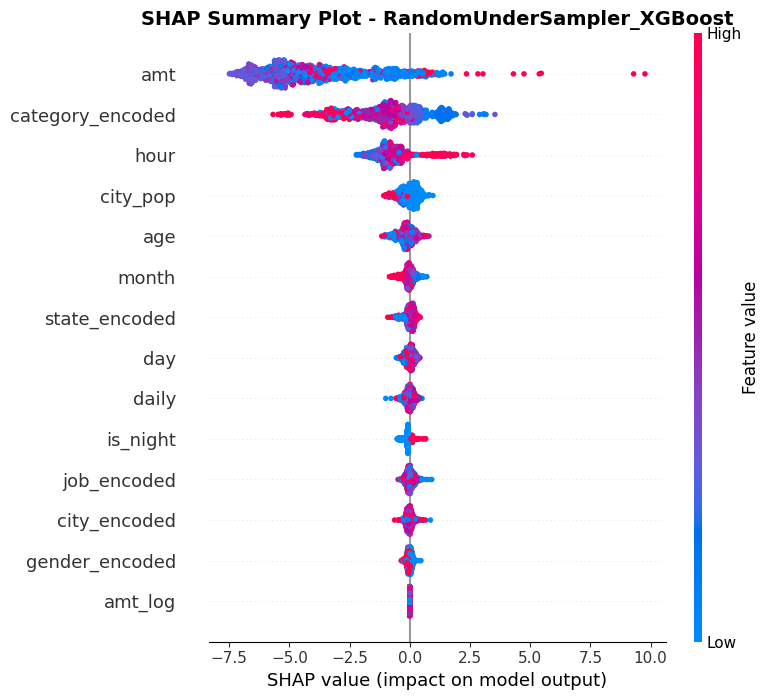

📈 Creating feature importance bar plot...


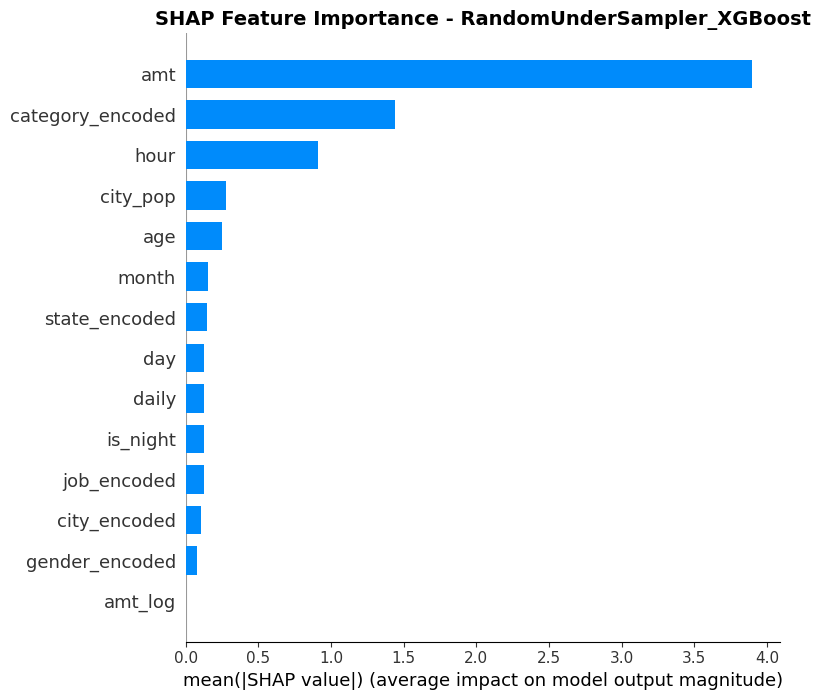

📈 Creating waterfall plot for a fraud case...


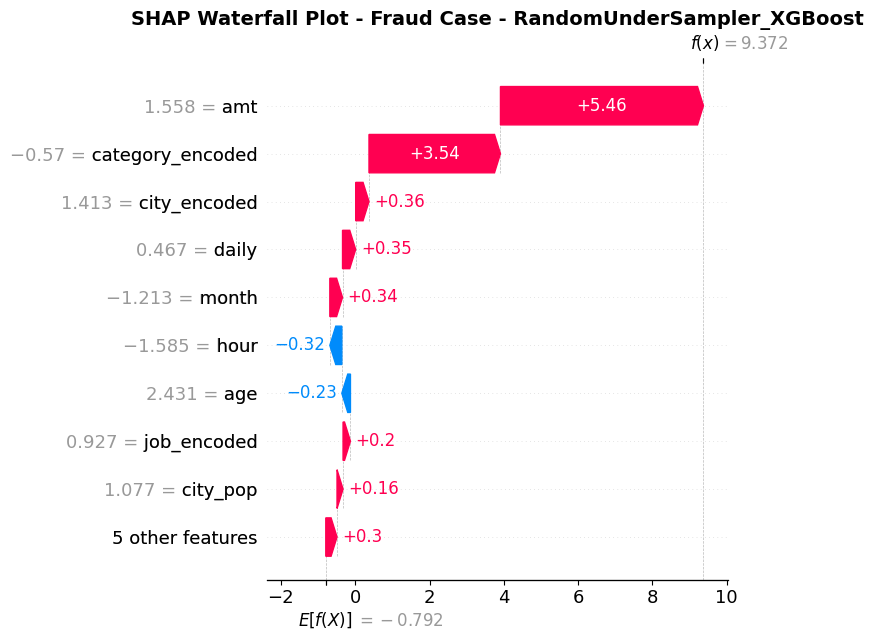

📈 Creating waterfall plot for a genuine case...


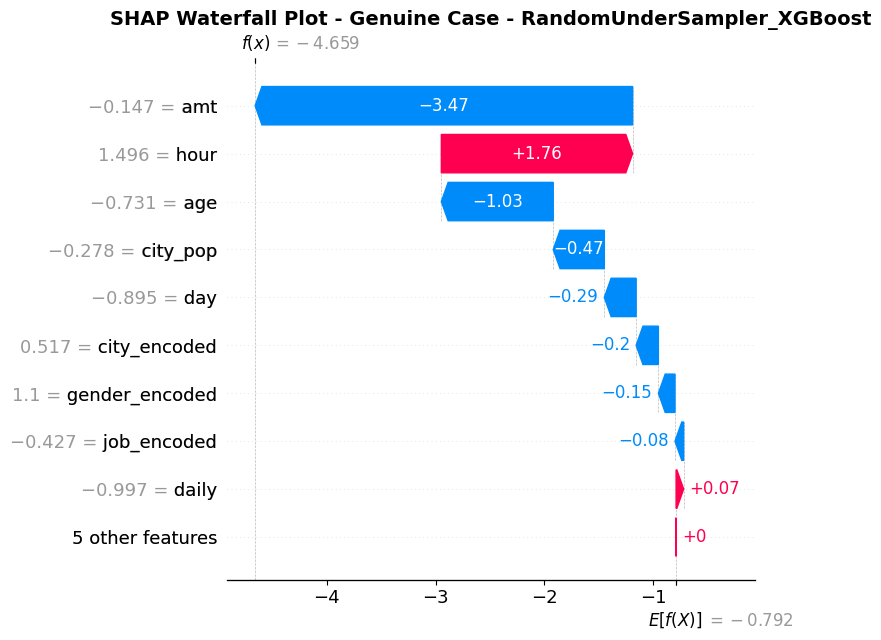

📈 Creating dependence plots for top features...


<Figure size 1000x600 with 0 Axes>

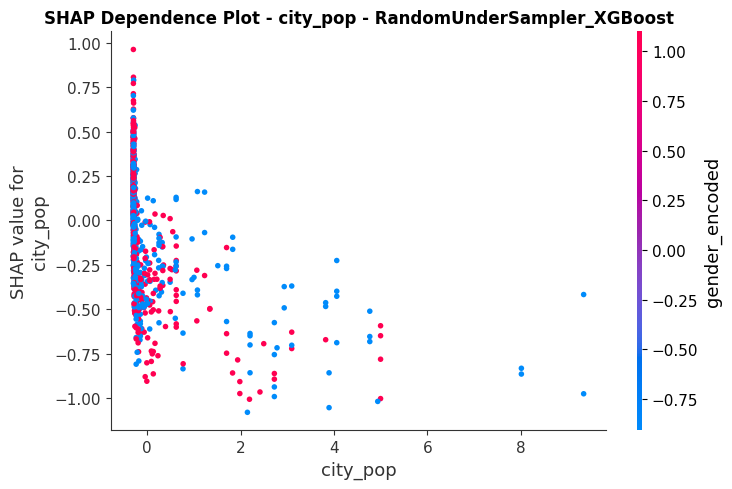

<Figure size 1000x600 with 0 Axes>

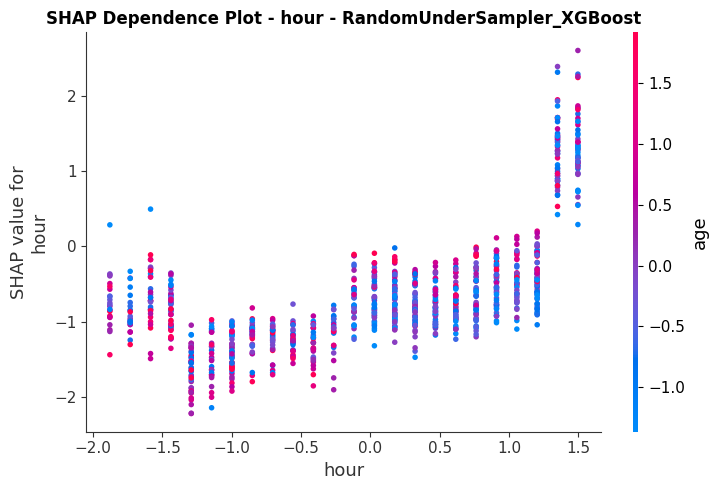

<Figure size 1000x600 with 0 Axes>

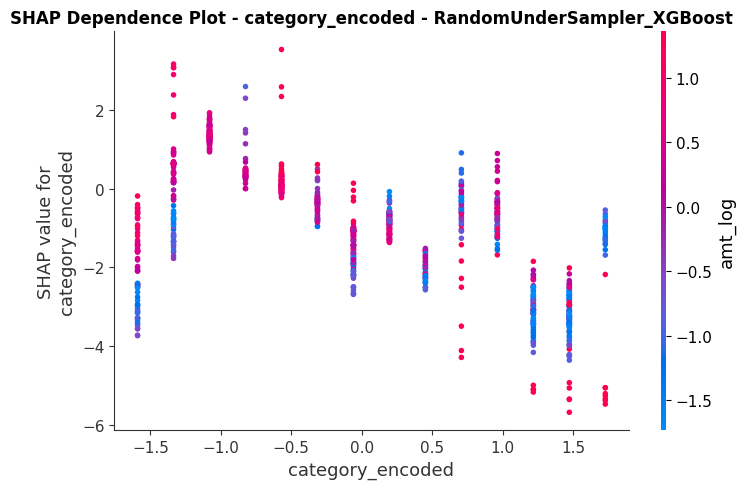

<Figure size 1000x600 with 0 Axes>

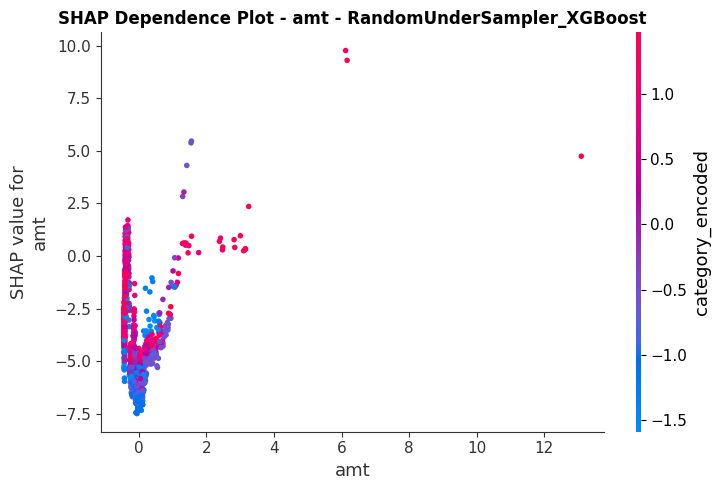


📋 SHAP ANALYSIS SUMMARY
🏆 Top 10 Most Important Features:
             feature  importance
1                amt      3.8943
0   category_encoded      1.4391
9               hour      0.9113
6           city_pop      0.2791
8                age      0.2465
12             month      0.1545
5      state_encoded      0.1440
11               day      0.1268
10             daily      0.1265
13          is_night      0.1252

✅ Feature importance saved as: shap_feature_importance_RandomUnderSampler_XGBoost.csv

🔍 KEY INSIGHTS:
• Top 3 most important features: amt, category_encoded, hour
• Features that typically increase fraud probability:
  - amt: +6.2285
  - category_encoded: +1.6563
  - hour: +0.5854
  - month: +0.1693
  - job_encoded: +0.1499
✅ SHAP values saved as: shap_values_RandomUnderSampler_XGBoost.json

📁 SHAP Analysis files generated:
   • shap_summary_plot_RandomUnderSampler_XGBoost.png
   • shap_feature_importance_RandomUnderSampler_XGBoost.png
   • shap_waterfall_fraud_RandomUn

In [ ]:
# =============================================================================
# Model Explainability with SHAP
# =============================================================================
import shap
print("\n" + "="*80)
print("🔍 MODEL EXPLAINABILITY WITH SHAP")
print("="*80)

print(f"\nAnalyzing explainability for the best model: {best_model_name}")

# Get the underlying XGBoost model from the best pipeline/model
if hasattr(best_model, 'named_steps'):
    # It's a pipeline, extract the XGBoost model
    xgb_model_for_shap = best_model.named_steps['xgb']
    print("📝 Extracted XGBoost model from pipeline")
elif hasattr(best_model, '_final_estimator'):
    # Alternative pipeline structure
    xgb_model_for_shap = best_model._final_estimator
    print("📝 Extracted XGBoost model from pipeline (alternative structure)")
else:
    # It's a standalone XGBoost model
    xgb_model_for_shap = best_model
    print("📝 Using standalone XGBoost model")

# Prepare sample data for SHAP analysis
print("🔄 Preparing data for SHAP analysis...")

# Use a sample of validation data for faster SHAP computation
sample_size = min(1000, len(X_val))
X_val_sample = X_val.sample(n=sample_size, random_state=42)
y_val_sample = y_val.loc[X_val_sample.index]

print(f"📊 Using {sample_size} samples for SHAP analysis")

# For pipeline models, we need to transform the data through the pipeline first
if hasattr(best_model, 'named_steps'):
    # Transform data through the pipeline (excluding the final estimator)
    X_transformed = X_train.copy()

    # Apply each step except the final XGBoost model
    for step_name, step in best_model.named_steps.items():
        if step_name != 'xgb':  # Skip the final XGBoost step
            if hasattr(step, 'fit_resample'):
                # It's a resampling step
                X_transformed, _ = step.fit_resample(X_transformed, y_train)
            elif hasattr(step, 'transform'):
                # It's a preprocessing step
                X_transformed = step.transform(X_transformed)

    # Use a sample of the transformed data
    X_shap_background = X_transformed.sample(n=min(100, len(X_transformed)), random_state=42)
    X_shap_sample = X_val_sample.copy()

else:
    # For standalone models, use the validation data directly
    X_shap_background = X_train.sample(n=100, random_state=42)
    X_shap_sample = X_val_sample.copy()

# Initialize SHAP explainer
print("🔄 Initializing SHAP explainer...")
try:
    # Use TreeExplainer for XGBoost models (faster and more accurate)
    explainer = shap.TreeExplainer(xgb_model_for_shap, X_shap_background)
    print("✅ Using TreeExplainer (recommended for XGBoost)")
except Exception as e:
    print(f"⚠️ TreeExplainer failed: {e}")
    print("🔄 Falling back to Explainer...")
    explainer = shap.Explainer(xgb_model_for_shap, X_shap_background)

# Calculate SHAP values
print("🔄 Calculating SHAP values...")
shap_values = explainer(X_shap_sample)

print("✅ SHAP analysis completed!")

# =============================================================================
# SHAP Visualizations
# =============================================================================
print("\n📊 Generating SHAP visualizations...")

# 1. Summary Plot (Feature Importance)
print("📈 Creating summary plot...")
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_shap_sample, feature_names=input_features, show=False)
plt.title(f'SHAP Summary Plot - {best_model_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'shap_summary_plot_{best_model_name}.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Bar Plot (Mean absolute SHAP values)
print("📈 Creating feature importance bar plot...")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_shap_sample, feature_names=input_features, plot_type="bar", show=False)
plt.title(f'SHAP Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'shap_feature_importance_{best_model_name}.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Waterfall plot for a fraud case (if available)
fraud_indices = y_val_sample[y_val_sample == 1].index
if len(fraud_indices) > 0:
    fraud_idx = fraud_indices[0]
    fraud_sample_idx = X_val_sample.index.get_loc(fraud_idx)

    print("📈 Creating waterfall plot for a fraud case...")
    plt.figure(figsize=(12, 8))
    shap.waterfall_plot(shap_values[fraud_sample_idx], show=False)
    plt.title(f'SHAP Waterfall Plot - Fraud Case - {best_model_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'shap_waterfall_fraud_{best_model_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

# 4. Waterfall plot for a genuine case
genuine_indices = y_val_sample[y_val_sample == 0].index
if len(genuine_indices) > 0:
    genuine_idx = genuine_indices[0]
    genuine_sample_idx = X_val_sample.index.get_loc(genuine_idx)

    print("📈 Creating waterfall plot for a genuine case...")
    plt.figure(figsize=(12, 8))
    shap.waterfall_plot(shap_values[genuine_sample_idx], show=False)
    plt.title(f'SHAP Waterfall Plot - Genuine Case - {best_model_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'shap_waterfall_genuine_{best_model_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

# 5. Dependence plots for top features
print("📈 Creating dependence plots for top features...")
# Get feature importance ranking
feature_importance = np.abs(shap_values.values).mean(0)
top_features_idx = np.argsort(feature_importance)[-4:]  # Top 4 features

for i, feat_idx in enumerate(top_features_idx):
    feature_name = input_features[feat_idx]
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(feat_idx, shap_values.values, X_shap_sample,
                        feature_names=input_features, show=False)
    plt.title(f'SHAP Dependence Plot - {feature_name} - {best_model_name}',
             fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'shap_dependence_{feature_name}_{best_model_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

# =============================================================================
# SHAP Analysis Summary
# =============================================================================
print("\n📋 SHAP ANALYSIS SUMMARY")
print("="*50)

# Feature importance ranking
feature_importance = np.abs(shap_values.values).mean(0)
feature_importance_df = pd.DataFrame({
    'feature': input_features,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("🏆 Top 10 Most Important Features:")
print(feature_importance_df.head(10).round(4))

# Save feature importance
feature_importance_df.to_csv(f'shap_feature_importance_{best_model_name}.csv', index=False)
print(f"\n✅ Feature importance saved as: shap_feature_importance_{best_model_name}.csv")

# Key insights
print("\n🔍 KEY INSIGHTS:")
top_3_features = feature_importance_df.head(3)['feature'].tolist()
print(f"• Top 3 most important features: {', '.join(top_3_features)}")

# Analyze positive vs negative contributions for fraud detection
fraud_cases = shap_values.values[y_val_sample == 1]
if len(fraud_cases) > 0:
    fraud_contributions = fraud_cases.mean(axis=0)
    positive_contributors = [(input_features[i], fraud_contributions[i])
                           for i in range(len(input_features))
                           if fraud_contributions[i] > 0]
    positive_contributors.sort(key=lambda x: x[1], reverse=True)

    print("• Features that typically increase fraud probability:")
    for feat, contrib in positive_contributors[:5]:
        print(f"  - {feat}: +{contrib:.4f}")

# Save SHAP values for later analysis
shap_data = {
    'shap_values': shap_values.values.tolist(),
    'feature_names': input_features,
    'sample_indices': X_shap_sample.index.tolist(),
    'predictions': xgb_model_for_shap.predict_proba(X_shap_sample)[:, 1].tolist()
}

with open(f'shap_values_{best_model_name}.json', 'w') as f:
    json.dump(shap_data, f, indent=2)

print(f"✅ SHAP values saved as: shap_values_{best_model_name}.json")

print("\n📁 SHAP Analysis files generated:")
print(f"   • shap_summary_plot_{best_model_name}.png")
print(f"   • shap_feature_importance_{best_model_name}.png")
print(f"   • shap_waterfall_fraud_{best_model_name}.png")
print(f"   • shap_waterfall_genuine_{best_model_name}.png")
print(f"   • shap_dependence_[feature]_{best_model_name}.png (for top 4 features)")
print(f"   • shap_feature_importance_{best_model_name}.csv")
print(f"   • shap_values_{best_model_name}.json")

print("\n🎯 SHAP analysis provides insights into:")
print("   • Which features are most important for fraud detection")
print("   • How each feature contributes to individual predictions")
print("   • Feature interactions and dependencies")
print("   • Model decision-making transparency")
